In [2]:
# conda activate ESE527
# Import the library
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from medcat.vocab import Vocab
from medcat.cdb import CDB
from medcat.cat import CAT
from medcat.meta_cat import MetaCAT
import textwrap
from rich import print 
import os
import json
import re
import pickle
import time
from tqdm.autonotebook import tqdm, trange
from concurrent.futures import ThreadPoolExecutor


c:\Users\judyw\Desktop\ESE527\project\.conda\Lib\site-packages\medcat\cat.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Large Language Model for Medical Forecasting using MIMIC-III Data
##### Juile Zhu, Yuyang Wu

## Background <br />

##### With the advancements in digitalization within the medical and healthcare system, unstructured text has become an essential component of Electronic Health Records (EHRs; Jackson et al., 2018). Natural Language Processing (NLP) models have already been widely applied to free-text data in EHRs and trained on real-world hospital datasets, yielding promising results. <br />

##### However, unlike traditional NLP models, there are limited experiments or recorded studies applying and evaluating the latest generation of Large Language Models (LLMs), such as GPT-4 or Gemini, in this domain. Most research focuses on physical tests or medical quizzes to validate these models, but their performance in analyzing complex clinical data for decision-making should not be overlooked.

## Executive Summary

### Target
**Fine-tuning large language models using MIMIC-III clinical notes to enhance its ability to accurately predict and interpret medical conditions, improving clinical decision support in ICU settings.**

### Decisions to be Impacted
Devisions to be impaced by this project are clinical decision-making in ICU settings:
1. **Diagnosis Support Decisions:**
   - The model may help clinicians interpret past unstructured clinical notes to better identify or confirm diagnoses.
2. **Prognostic Forecasting and Risk Prediction:**
   - Predicting patient outcomes, e.g. risk of mortality, diseases, complications, etc.
   - Supporting resource allocation by identifying high-risk patients early.
3. **Operational and Workflow Decisions:**
   - Reducing cognitive load on medical staff.
   - Supporting decisions on whether and how to integreate LLM-powered tools into clinical workflows.
   - Policies on AI-assisted decision-making in sensitive healthcare environments.

### Business Value 
  - **Hospital:** Optimized ICU resource allocation  
  - **Patient:** Improved patient outcomes since early intervension strategies are informed 
  - **Clinicians:** assisted with early and informed decisions about their patients
  - **Insurance companies:** Better risk predictions  

### Data assets
- **MIMIC-III**: accessible through the link https://physionet.org/content/mimiciii/1.4/.
#### Data Description:
- 40k+ patients data in critical care units
- 2M+ clinical notes
- diverse & large population of ICU patients
- Time range: 2001 to 2012
#### Data compositions (25 .csv files):
- **Demographics**
- Vital Signs
- Laboratory Tests
- Medications
- Diagnoses & Procedures
- **Clinical Notes**
- Prescriptions
- Survival Outcomes <br/>

Out of the 25 csv files, noteevents.csv, patients.csv, and admissions.csv are used for analysis. Patients and admissions provide supplementary information and note events provide the clinical notes that are the foundation for the project. The next section introduces each files and the information extracted from each file. 
- **Reason for Choosing Clinical notes:**  
  - Physician’s high-level summary of patients’ entire medical information  
  - Added interpretation and reasoning, most relevant details  


## Data Overview and Visualization


In [3]:
# Read all of csv file
# Read the required csv file first
note_event_df = pd.read_csv('Data/NOTEEVENTS.csv', low_memory=False)
patients_df = pd.read_csv('Data/PATIENTS.csv', low_memory=False)
admissions_df = pd.read_csv('Data/ADMISSIONS.csv',  low_memory=False)
icu_stays = pd.read_csv('Data/ICUSTAYS.csv')

**PATIENTS.csv**
- Gender, DOB, DOD are extracted as supplementary information.
- SUBJECT_ID is used to track the same patient across files.

In [22]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaT,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaT,NaN,NaN,0
3,237,252,M,2078-03-06,NaT,NaN,NaN,0
4,238,253,F,2089-11-26,NaT,NaN,NaN,0


**ADMISSIONS.csv**
- ADMITTIME, DISCHTIME, ETHNICITY are extracted as supplementary information.

In [23]:
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,HOSPITAL_STAY_DAYS
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3


**NOTEEVENTS.csv**
- Contains 2M+ clinical notes.
- Its text column contains the clinical notes that will later be extracted and used for finetuning the models.
- CHARTDATE is used as time stamp of each clinical note.

In [24]:
note_event_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,time
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...,2151-08-04T00:00:00
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...,2118-06-14T00:00:00
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...,2119-05-25T00:00:00
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,2124-08-18T00:00:00
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...,2162-03-25T00:00:00


In [25]:
note_event_df['TEXT'].isna().sum()

0

#### Outlier Check
##### Since there is no NA value in the text column of note events, all clinical notes will be included and processed for now. The cleaning process will occur at tokenization where only interested disease, medications, procedures, and symptoms terms and their context will be extracted. 

In [26]:
# Sample clinical note
first_patient_text = note_event_df.loc[13, 'TEXT']
print(first_patient_text)

Admission Date:  [**2143-4-25**]     Discharge Date:  [**2143-4-30**]

Date of Birth:   [**2076-8-18**]     Sex:  M

Service:  Cardiac Surgery

CHIEF COMPLAINT:  Chest pain, 3-vessel disease on
catheterization.

HISTORY OF PRESENT ILLNESS:  The patient is a 66-year-old
male transferred from [**Hospital6 33**] to the [**Hospital1 346**] status post catheterization,
revealing 3-vessel cardiac disease.

The patient presented to [**Hospital6 33**] with gradually
increasing chest pain over the past three to four months to
the point that he had chest pain with minimal exertion.

PAST MEDICAL HISTORY:
1.  Known coronary artery disease, status post
catheterization 10 years ago at [**Hospital1 **].
2.  Heavy smoker.
3.  Hypertension.
4.  Gastroesophageal reflux disease/peptic ulcer disease.
5.  Wegener granulomatosis with complete resolution.
6.  Glaucoma.

PAST SURGICAL HISTORY:  Perforated ulcer.

MEDICATIONS ON ADMISSION:  Lisinopril 20 mg p.o. q.d.,
Prilosec 20 mg p.o. q.d., Cosopt eyedrops, Alphagan eyedrops,
Travatan eyedrops, lansoprazole 50 mg p.o. q.d.

ALLERGIES:  No known drug allergies.

HOSPITAL COURSE:  The patient underwent an elective coronary
artery bypass graft times three on [**2143-4-26**] with grafts
being a left internal mammary artery to left anterior
descending artery, saphenous vein graft to ramus, and
saphenous vein graft to posterior descending artery.  He was
extubated on the day of surgery.  On postoperative day one,
his nasogastric tubes were discontinued.

He was transferred to the regular floor on postoperative day
one.  He subsequently had a smooth postoperative course.  His
pacing wires were discontinued on postoperative day three.

By postoperative day, he was ambulating well.  He was
comfortable on p.o. pain medication, and he was ready for
discharge home.

MEDICATIONS ON DISCHARGE:
1.  Lasix 20 mg p.o. q.d. (for one week).
2.  KCL 20 mEq p.o. q.d. (for one week).
3.  Colace 100 mg p.o. b.i.d.
4.  Zantac 150 mg p.o. b.i.d.
5.  Enteric-coated aspirin 325 mg p.o. q.d.
6.  Alphagan eyedrops.
7.  Lopressor 50 mg p.o. b.i.d.
8.  Nicoderm patch 22 mg q.d.
9.  Percocet one to two tablets p.o. q.4-6h. p.r.n.

DI[**Last Name (STitle) 408**]E FOLLOWUP:  Follow up with primary care physician,
[**Last Name (NamePattern4) **]. [**First Name4 (NamePattern1) **] [**Last Name (NamePattern1) 2208**], in two 
weeks and with Dr. [**Last Name (Prefixes) **] in
four weeks.

CONDITION AT DISCHARGE:  Condition on discharge was stable.

DISCHARGE STATUS:  Discharged to home.




                          [**Doctor Last Name 412**] [**Last Name (Prefixes) 413**], M.D.  [**MD Number(1) 414**]

Dictated By:[**Last Name (NamePattern1) 2209**]

MEDQUIST36

D:  [**2143-4-30**]  15:09
T:  [**2143-4-30**]  15:31
JOB#:  [**Job Number 2211**]

#### Description of Clinical Note
##### The sample clinical note above showcase the information included for later analysis. Unlike traditional risk prediction models that focused on structured data and quantitative measures, such as lab test result and vital signs, the unstructured clinical notes capture unique clinical narrative and reflect clinical judgment and thought process. Clincal notes are not limited to what is measured or charted numerically as symptoms, history, social factors, and comorbidities can be included. They can also reveal the progression of symptoms, response to treatment, or suddent deterioration over time. Using clinical notes, the model may learn to mimics how clinicians think and communicate, enabling better alignment with real-life decision-making. 

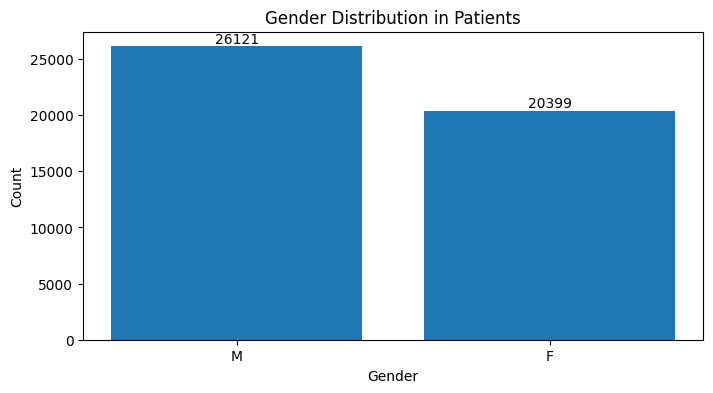

In [4]:
# Gender Distribution
gender_counts = patients_df["GENDER"].value_counts()
plt.figure(figsize=(8, 4))
# GPT: edit the code to show number on top of histogram
bars = plt.bar(gender_counts.index, gender_counts.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', ha='center', va='bottom', fontsize=10)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution in Patients")
plt.xticks(rotation=360)
plt.show()

#### Picture of Gender Distribution Analysis
##### There is an imbalanced gender representation in the dataset, with a higher number of male patients. The difference could reflect real-world ICU admission trends. In the later model training process, the gender imbalance might introduce biases and potentially influence model performance for male and female patients. 

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'WHITE'),
  Text(1, 0, 'BLACK'),
  Text(2, 0, 'HISPANIC/LATINO'),
  Text(3, 0, 'ASIAN'),
  Text(4, 0, 'NATIVE'),
  Text(5, 0, 'OTHER')])

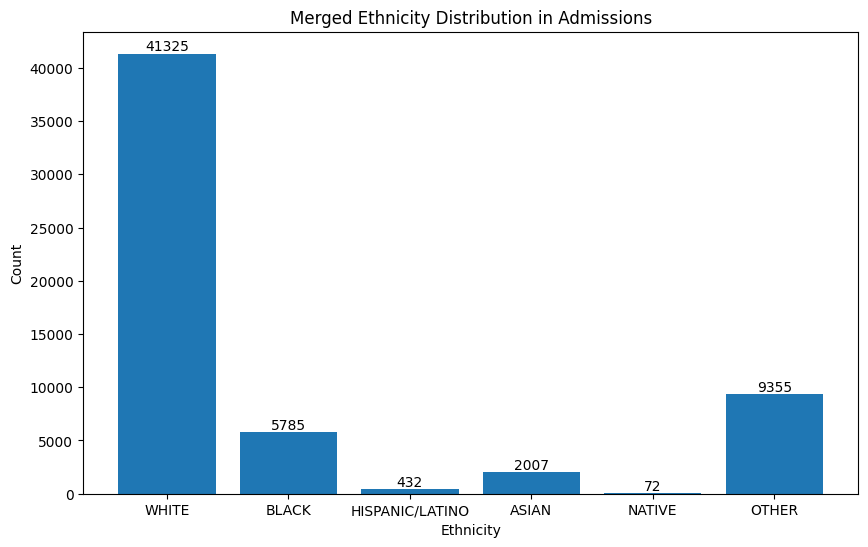

In [5]:
# Ethnicity Distribution
ethnicity_counts = admissions_df["ETHNICITY"].value_counts()
merged_ethnicity_counts = {
    "WHITE": 0,
    "BLACK": 0,
    "HISPANIC/LATINO": 0,
    "ASIAN": 0,
    "NATIVE": 0,
    "OTHER": 0,
}
for ethnicity, count in ethnicity_counts.items():
    if "WHITE" in ethnicity:
        merged_ethnicity_counts["WHITE"] += count
    elif "ASIAN" in ethnicity:
        merged_ethnicity_counts["ASIAN"] += count
    elif "BLACK" in ethnicity:
        merged_ethnicity_counts["BLACK"] += count
    elif "HISPANIC/LATINO" in ethnicity:
        merged_ethnicity_counts["HISPANIC/LATINO"] += count
    elif "NATIVE" in ethnicity:
        merged_ethnicity_counts["NATIVE"] += count
    else:
        merged_ethnicity_counts["OTHER"] += count

merged_ethnicity_series = pd.Series(merged_ethnicity_counts)
plt.figure(figsize=(10, 6))
bars = plt.bar(merged_ethnicity_series.index, merged_ethnicity_series.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', 
             ha='center', va='bottom', fontsize=10)
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.title("Merged Ethnicity Distribution in Admissions")
plt.xticks(rotation=360)

#### Bar Plot of Merged Ethnicity Distribution in Admission Anaylsis
##### The above bar chart represents the race distribution of admissions in the MIMIC-III dataset, showing a significant imbalance among different racial groups. The vast majority of patients are labeled as white while other racial groups have significantly fewer records. This disparity may be due to the demographics of the hospital that provided the data, which are critical care units of the Beth Israel Deaconess Medical Center. Since white patients dominate the dataset, the fine-tuned LLM on MIMIC-III notes may perform better on white patients and predictions for other ethnicity groups may be less accurate, leading to disparities in AI-driven decision support. Stratified analysis may be used to evaluating model performance separately for different racial groups. 

In [6]:
# Different Diagnosis in the ADMISSION.csv
diagnosis_counts = admissions_df['DIAGNOSIS'].value_counts().reset_index()
diagnosis_counts.columns = ['Diagnosis', 'Count']
# Calculate the mortality of the different Diagnosis
mortality_counts = admissions_df[admissions_df['HOSPITAL_EXPIRE_FLAG'] == 1]['DIAGNOSIS'].value_counts().reset_index()
mortality_counts.columns = ['Diagnosis', 'Mortality Count']

diagnosis_mortality_df = pd.DataFrame({
    'Diagnosis': diagnosis_counts['Diagnosis'],
    'Count': diagnosis_counts['Count'],
    'Mortality Count': diagnosis_counts.merge(mortality_counts, on='Diagnosis', how='left')['Mortality Count'].fillna(0).astype(int)
})
diagnosis_mortality_df['Mortality Rate (%)'] = (diagnosis_mortality_df['Mortality Count'] / diagnosis_mortality_df['Count']) * 100
diagnosis_mortality_df.head(11)

,Diagnosis,Count,Mortality Count,Mortality Rate (%)
0,NEWBORN,7823,62,0.792535
1,PNEUMONIA,1566,264,16.858238
2,SEPSIS,1184,267,22.550676
3,CONGESTIVE HEART FAILURE,928,126,13.577586
4,CORONARY ARTERY DISEASE,840,23,2.738095
5,CHEST PAIN,778,52,6.683805
6,INTRACRANIAL HEMORRHAGE,713,231,32.398317
7,ALTERED MENTAL STATUS,712,88,12.359551
8,GASTROINTESTINAL BLEED,686,57,8.309038
9,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,583,1,0.171527


#### Diagnosis Analysis
##### The dataset represents conditions commonly managed in ICUs, indicating that the model may overfit to high-acuity cases and perform worse on less critical conditions. Some diagnoses are merged such as "CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...", indicating data cleaning and medical term extraction are needed for reliable model training. The data supports the importance of early warning systems for high-risk conditions such as intracranial hemorrhage with a 32.4% mortality rate. A fine-tuned LLM trained on clinical notes could help predict worsening conditions early and guide timely interventions. 


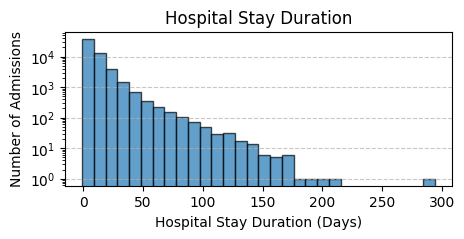

HOSPITAL_STAY_DAYS
-1        98
 0      2194
 1      3473
 2      5715
 3      5138
        ... 
 181       1
 191       1
 202       1
 206       1
 294       1
Name: count, Length: 162, dtype: int64

In [7]:
# Patient's stay in the hospital.
# Convert the DISCHTIME and ADMITTIME from object to date time format
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'], errors='coerce') 
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'], errors='coerce')

# Get the lengths
admissions_df['HOSPITAL_STAY_DAYS'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']).dt.days
plt.figure(figsize=(5, 2))
plt.hist(admissions_df['HOSPITAL_STAY_DAYS'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Hospital Stay Duration (Days)')
plt.ylabel('Number of Admissions')
plt.yscale('log')
plt.title('Hospital Stay Duration')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# Print the table about the hospital_stay_counts
hospital_stay_counts = admissions_df['HOSPITAL_STAY_DAYS'].value_counts().sort_index()
print(hospital_stay_counts)
patients_negative_stay = admissions_df[admissions_df['HOSPITAL_STAY_DAYS'] == -1]

#### Stay Duration Analysis 
##### The dataset shows a highly skewed distribution in hospital stays as most hospital stays are shot, 0~10 days. There are 98 cases with -1 days which may indicate data entry erros and may be cleaned before model training. One potential clinical insights out of the plot is understanding what factors contribute to long hosptial stays and it can improve hospital resource planning. 

## Data Processing

#### Dataset Files Description

- **NOTEEVNTS.csv**  
  - **Content:** Contains detailed and valid doctor notes  
  - **Size:** Over 2,000,000 rows  
  - **Target info:** ROW_ID, TEXT, CHARTDATE, SUBJECT_ID  

- **ADMISSION.csv**  
  - **Content:** Contains general information about patients  
  - **Size:** 58,976 rows  
  - **Target info:** ADMITTIME, DISCHTIME, ETHNICITY 

- **Patient.csv**  
  - **Content:** Contains detailed information about patients  
  - **Size:** 46,520 rows  
  - **Target info:** SUBJECT_ID, DOB, DOD, Gender 

#### Data Processing Steps
1. **Biomedical Concept Extraction**  
   - **MedCAT**: Identify and extract medical concepts from unstructured text  
   - **SNOMED CT**: Provide concept unique identifier (CUI)  
   - **Example**: Heart failure - `84114007`  

2. **Replace medical concepts with their code**  

3. **Tokenizer**  
   - Biomedical concept + its contexts  

4. **Order extracted concepts in time and group by the patient**  
   - Form a patient timeline  

5. **Add complementary info**  
   - Age, ethnicity, sex, etc.

6. **Reconstruct a singular clinical note for each patient**
   - A 25 year-old man complains of 51197009 and 22253000. He reports having 398032003 and losing 6.8 kg over a 3-month duration. He also reports increased 84229001. On physical examination, his 56342008 is 38.6°C.

# NLP Tool

## **MEDCAT**  
It can be used to extract information from Electronic Health Records (EHRs) and link it to biomedical ontologies like SNOMED-CT and UMLS.  

- **Version:** 1.15  
- **CDB and Vocab:** Pre-trained on the National Library of Medicine  
  - **Version:** SNOMED International (Full SNOMED model pack trained on MIMIC-III)  



In [11]:
# Load the vocab model we downloaded 
vocab = Vocab.load("medcat_models/vocab.dat")
# Load the cdb model you downloaded
cdb = CDB.load('medcat_models/cdb.dat') 

c:\Users\judyw\Desktop\ESE527\project\.conda\Lib\site-packages\pydantic\main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `set[str]` but got `dict` with value `{}` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
which may or may not work. If you experience any compatibility issues, please reinstall MedCAT
or download the compatible model.


In [12]:
# Run the medcat_status model
mc_status = MetaCAT.load("medcat_models/meta_Status")

c:\Users\judyw\Desktop\ESE527\project\.conda\Lib\site-packages\medcat\meta_cat.py:430: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta_cat.model.load_state_dict(torch.loa

In [14]:
# Initial the CAT
cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab, meta_cats=[mc_status])


In [15]:
# Medcat Example 
example_text = note_event_df['TEXT'][0]
print(example_text)

example_entity = cat.get_entities(example_text)
print(example_entity["entities"][0])


Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]


Service:
ADDENDUM:

RADIOLOGIC STUDIES:  Radiologic studies also included a chest
CT, which confirmed cavitary lesions in the left lung apex
consistent with infectious process/tuberculosis.  This also
moderate-sized left pleural effusion.

HEAD CT:  Head CT showed no intracranial hemorrhage or mass
effect, but old infarction consistent with past medical
history.

ABDOMINAL CT:  Abdominal CT showed lesions of
T10 and sacrum most likely secondary to osteoporosis. These can
be followed by repeat imaging as an outpatient.



                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name 
(NamePattern1) **], M.D.  [**MD Number(1) 1776**]

Dictated By:[**Hospital 1807**]
MEDQUIST36

D:  [**2151-8-5**]  12:11
T:  [**2151-8-5**]  12:21
JOB#:  [**Job Number 1808**]

{
    'pretty_name': 'Hospital admission',
    'cui': '32485007',
    'type_ids': ['28321150'],
    'types': ['procedure'],
    'source_value': 'Admission',
    'detected_name': 'admission',
    'acc': 1.0,
    'context_similarity': 1.0,
    'start': 0,
    'end': 9,
    'icd10': [],
    'ontologies': ['SNOMED-CT'],
    'snomed': [],
    'id': 0,
    'meta_anns': {'Status': {'value': 'Other', 'confidence': 0.7512198686599731, 'name': 'Status'}}
}

In [16]:
# Take out the necessary info and store them into json format
copy_NOTEEVENTS = note_event_df
# NOTEEVENT.CSV
Note_info = dict(zip(copy_NOTEEVENTS['ROW_ID'].astype(str), copy_NOTEEVENTS['TEXT']))

# Convert the string to the date format
copy_NOTEEVENTS['CHARTDATE'] = pd.to_datetime(copy_NOTEEVENTS['CHARTDATE'])
# create a new columns called name
copy_NOTEEVENTS['time'] = copy_NOTEEVENTS['CHARTDATE'].apply(lambda x: x.isoformat() if pd.notna(x) else None)
# Get a copy for the note_event to avoid change 
copy_NOTEEVENTS['ROW_ID'] = copy_NOTEEVENTS['ROW_ID'].astype(str)
bridge_info = copy_NOTEEVENTS.set_index('ROW_ID').to_dict(orient='index')
bridge_info = {k: {'pt': str(v['SUBJECT_ID']), 'time': v['time']} for k, v in bridge_info.items()}

# Get the supplementary info 
# Copy the patient info dataframe first 
copy_PATIENT = patients_df
# Convert the date of birth and date of death into the date format
copy_PATIENT['DOB'] = pd.to_datetime(copy_PATIENT['DOB'])
copy_PATIENT['DOD'] = pd.to_datetime(copy_PATIENT['DOD'])

# Initilize a dict
patients_info = {}
# Use th iterrows to iterates each row to access the data 
for _, row in patients_df.iterrows():
    patient_id = str(row['SUBJECT_ID'])
    sex = 'Female' if row['GENDER'] == 'F' else ('Male' if row['GENDER'] == 'M' else 'Unknown')
    dob = row['DOB'].isoformat() if pd.notna(row['DOB']) else None
    dod = row['DOD'].isoformat() if pd.notna(row['DOD']) else None
    patients_info[patient_id] = {'Sex': sex, 'DOB': dob, 'DOD': dod}

# Fill the ethenity info
for _, row in admissions_df.iterrows():
    patient_id = str(row['SUBJECT_ID'])
    eth = row['ETHNICITY'] if pd.notna(row['ETHNICITY']) else 'Unknown'
    if patient_id in patients_info:
        patients_info[patient_id]['eth'] = eth




In [17]:
import json
import pickle
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

OUTPUT_FILE = "entities_output.jsonl"
PROCESSED_FILE = "processed_ids.pkl"

try:
    with open(PROCESSED_FILE, "rb") as f:
        processed_ids = pickle.load(f)
except FileNotFoundError:
    processed_ids = set()

def extract_entities(doc_id_text):
    doc_id, text = doc_id_text
    entities = cat.get_entities(text)

    entities_list = list(entities.get("entities", {}).values())

    return {"doc_id": doc_id, "entities": entities_list}

try:
    with open(OUTPUT_FILE, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            processed_ids.add(data["doc_id"])  
except FileNotFoundError:
    pass  

# unprocessed `doc_id`
remaining_items = {k: v for k, v in Note_info.items() if k not in processed_ids}

# Process the first 2000 row id data
remaining_items_2000 = dict(list(remaining_items.items())[:2000])
# initialization
buffer = []
buffer_size = 1000  

# Initialize the process bar
total_docs = len(remaining_items_2000)
progress_bar = tqdm(total=total_docs, dynamic_ncols=True, unit="doc", desc="Processing", mininterval=2)

start_time = time.time()  # record the time

# 处理数据并存储
with ThreadPoolExecutor(max_workers=4) as executor:
    with open(OUTPUT_FILE, "a", encoding="utf-8") as f:
        for output in executor.map(extract_entities, remaining_items_2000.items()):
            doc_id = output["doc_id"]

            # record the already processed ids
            if doc_id not in processed_ids:
                processed_ids.add(doc_id)

            # Store in buffer
            buffer.append(json.dumps(output) + "\n")

            # write in the buffer
            if len(buffer) >= buffer_size:
                f.writelines(buffer)
                buffer = []

                # store the id into pickle file
                with open(PROCESSED_FILE, "wb") as pkl_f:
                    pickle.dump(processed_ids, pkl_f)

            # Update the visualization of the process
            progress_bar.update(1)
            elapsed_time = time.time() - start_time
            docs_processed = len(processed_ids)
            # Avoid the when docs_processed == 0
            if docs_processed > 0:
                estimated_time = (elapsed_time / docs_processed) * (total_docs - docs_processed)
                progress_bar.set_postfix({"ETA": f"{estimated_time:.2f}s"})


# final store in the buffer
if buffer:
    with open(OUTPUT_FILE, "a", encoding="utf-8") as f:
        f.writelines(buffer)

# save all ids
with open(PROCESSED_FILE, "wb") as pkl_f:
    pickle.dump(processed_ids, pkl_f)

# close the bar
progress_bar.close()



"""
GPT Citation:
Prompt: 
rom concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=4) as executor:
    for output in executor.map(extract_entities, Note_info.items()): Could you please help me safely generate the json file? 

Answer: 
The above code is the result. 

"""

Processing: 100%|██████████| 2000/2000 [18:08<00:00,  1.84doc/s, ETA=-544.13s]


'\nGPT Citation:\nPrompt: \nrom concurrent.futures import ThreadPoolExecutor\n\nwith ThreadPoolExecutor(max_workers=4) as executor:\n    for output in executor.map(extract_entities, Note_info.items()): Could you please help me safely generate the json file? \n\nAnswer: \nThe above code is the result. \n\n'

In [18]:
# File routine 
ENTITIES_FILE = "entities_output.jsonl"
PROCESSED_TEXT_FILE = "processed_text.jsonl"
PROCESSED_DOCS_FILE = "processed_docs.pkl"

# Check whether the doc id already processed 
try:
    with open(PROCESSED_DOCS_FILE, "rb") as f:
        processed_docs = pickle.load(f)
except FileNotFoundError:
    processed_docs = set()

# Update the replaced text
updated_data = {}

# Read the entities output jsonl
with open(ENTITIES_FILE, "r", encoding="utf-8") as f:
    lines = f.readlines()
# Initial the process bar
for line in tqdm(lines, desc="Replacing Entities with CUI"):
    data = json.loads(line)
    doc_id = data["doc_id"]

    # skipped the exist doc id
    if doc_id in processed_docs:
        continue
    # Access the each entity in the entity files
    entities = data["entities"]

    # Access the original notevent files
    if doc_id in Note_info:
        text = Note_info[doc_id]

        # reverse the entities content to avoid changing index
        for entity in sorted(entities, key=lambda e: e["start"], reverse=True):  
            if any(t in ["disorder", "symptom", "finding", "medication"] for t in entity["types"]):
            
                start, cui, end = entity["start"],entity["cui"], entity["end"]
            
                prefix = " " if start > 0 and text[start - 1] != " " else ""
                suffix = " " if end < len(text) and text[end] != " " else ""

                # reform the text
                text = text[:start] + f"{prefix}{cui}{suffix}" + text[end:]

        
        updated_data[doc_id] = text

        
        processed_docs.add(doc_id)

    # every 1000 times, clean the buffer
    if len(processed_docs) % 1000 == 0:
        with open(PROCESSED_DOCS_FILE, "wb") as f:
            pickle.dump(processed_docs, f)

# write in `processed_text.jsonl
with open(PROCESSED_TEXT_FILE, "w", encoding="utf-8") as f:
    for doc_id, text in updated_data.items():
        f.write(json.dumps({"doc_id": doc_id, "text": text}) + "\n")

# final save
with open(PROCESSED_DOCS_FILE, "wb") as f:
    pickle.dump(processed_docs, f)

Replacing Entities with CUI: 100%|██████████| 4000/4000 [00:16<00:00, 235.87it/s]


In [19]:

PROCESSED_TEXT_FILE = "processed_text.jsonl"
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def save_jsonl(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + "\n")
            
def add_allinfo (PROCESSED_TEXT_FILE, bridge_info, patients_info, output_path):
    # READ THE JSONL FILE
    processed_data = load_jsonl(PROCESSED_TEXT_FILE)
    MERGED_DATA = []

    for line in processed_data:
        doc_id = line.get("doc_id")
        # Use the row data to track in the bridge info 
        if doc_id in bridge_info:
            line.update(bridge_info[doc_id])
            # Based find bridge info, we will access corresponding subject id (patient id)
            pt = bridge_info[doc_id].get("pt")
            if pt in patients_info:
                line.update(patients_info[pt])
        MERGED_DATA.append(line)
    save_jsonl(MERGED_DATA, output_path)

MERGED_PATH = "merged_text.jsonl"
add_allinfo(PROCESSED_TEXT_FILE, bridge_info, patients_info, MERGED_PATH)

### Tokenization / Mistral-7B-Instruct-v0.1
#### Import the required packages
- The Pretrained model comes from the HUGGING FACE: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1

In [20]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
from dotenv import load_dotenv
# Load the .env file
load_dotenv()

# Logging the hugging face 
token = os.getenv("HUGGINGFACE_TOKEN")

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", token = token)
Mistral_model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", token = token)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#### Load the json file with the merged file


In [21]:

merged_data = load_jsonl(MERGED_PATH)

# Because we want to get all of cui as the additional token\\
cui_pattern = re.compile(r'\d{6,}')
extract_cui = set()
for m_data in merged_data:
    cuis = cui_pattern.findall(m_data['text'])
    #print(cuis)
    extract_cui.update(cuis)

print("Total unique CUIs:", len(extract_cui))



Total unique CUIs: 4970

In [22]:

# Solve the question about the empty pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # 使用 eos_token 作为填充 token

tokenized_data = []
for data in merged_data:
    doctor_note = data['text']
    encoding = tokenizer(doctor_note,
                         padding= "max_length",
                         max_length= 1024,
                         truncation = True,
                         return_tensors= "pt")
    tokenized_data.append(encoding)


print(tokenized_data[:5])

[
    {
        'input_ids': tensor([[    1,  1964,  6306,  ..., 28781, 28782, 28750]]),
        'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])
    },
    {
        'input_ids': tensor([[    1,  1964,  6306,  ..., 28747, 24724, 28762]]),
        'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])
    },
    {
        'input_ids': tensor([[    1,  1964,  6306,  ..., 28793,   983,  9751]]),
        'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])
    },
    {
        'input_ids': tensor([[    1,  1964,  6306,  ..., 28770, 28823, 28705]]),
        'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])
    },
    {
        'input_ids': tensor([[    1,  1964,  6306,  ..., 28783,   399,  4738]]),
        'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])
    }
]

## Models

### Pretrained Large Language Models
  1. **LLaMAv2-7B**
     - Highly optimized transformer model, known for efficiency and improved context handling. Its strong performance in reasoning tasks makes it ideal for clinical decision support.
  2. **Mistralv0.1-7B**
     - Robust generalization ability with strong performance in domain adaptation when fine-tuned. It is well-suited for text generation and summarization and has an efficient model size (7B parameters) that is feasible for deployment in healthcare applications with limited computational resources. 
- Both models are **general-purpose models** with strengths in text processing.
- Fine-tuned on **real ICU patient records**  
- Processed MIMIC-III data
The LLaMA v2-7B and Mistralv0.1-7B are chosen for fine-tuning using MIMIC-III clinical notes for this project. These models are well-suited for medical forecasting and clinical decision support due to their efficiency and ability to process unstructured text. Due to the size of the model as well as the training data, the university's GPU resources are currently in the process of acquiring accessibility. 



### Machine Learning Morphism (MLM)
1. **Data Processing**
   1) Biomedical concept extraction using MedCat
   2) Replace medical concepts with their CUI code
   3) Tokenization of biomedical concepts, contexts, and time stamps
   4) For a patient timeline: order extracted concepts in time and group by the patient
   5) Add complementary information such as age, ethnicity, and gender.
   6) Reconstruct a singular clinical note for each patient.
   7) Dataset split: 95% of patients for training, 5% for testing. 
2. **Fine-Tuning**
   - Fine-tuning pre-trained LLM models on the processed data. The exact fine-tuning methods will depend on the accessible resources. If sufficient GPU resources are available, we may proceed to fine-tune all model weights, leveraging the full capacity of the 7B models. If not, we will apply parameter-efficient adapters such as LoRA.
   1) General clinical timeline modeling
      - The first stage of training is to predict the next biomedical concept given the preceding sequence of text and concepts, tailored to clinical timelines. 
   2) Risk forecasting task
      - The second stage of fine-tuning is for the risk forecasting task. A separate dataset will be constructed to predict which new diagnoses a patient will develop in the next month.
3. **Model Training & Hyperparameters**
   - Training setup: The exact parameters (max sequence length, optimizer, batch size, etc.) will be decided upon once the available GPU resources are clarified.
4. **Evaluation and Model Performance**
   1) Next Concept Prediction
   2) Risk Forecasting
   - Compared with other LLMs such as BioMistral, GPT-4, and MedAlpaca using the evaluation metric below.

### Evaluation Metric
- **Next Concept Prediction: How many of the predictions (disease names) match the ground truth?**
  - Predicted concept X is considered correct if it appears anywhere in the window of **30,365, inf** days in the patient timeline.
  - **Precision** = TP / (TP + FP)
  - **Recall** = TP / (TP + FN)

- **Risk Forecasting: Predict the top 5 disorders a patient is at risk of in the next month**
  - Compare **# correct predictions** between models
  - Sample prompt： Given the above patient history, what 5 specific new disorders is this patient at risk for in the next month?

## Next Steps
**6 weeks till final report**
- W1: Tokenization:
   1) convert current data into tokens which is used for the LLM model to train
   2) expand the LLM tokenizer to incorporate SNOMED CT and other medical terms
- W2: Extract context around medical concepts, Bucketing, filter, cleaning
  1) bucketing concepts by day
  2) emoving any concept that was mentioned only once in the entire record
- W3: Concatenate all biomedical concepts and their concepts to form a patient timeline
  1) merge extracted medical concepts with complementary information
  2) introduce time gap tokens, e.g. 7 days later to preserve the temporal flow
- W4-6: fine-tuning models and evaluation
  1) next concept prediction task
  2) risk forecasting task
  3) compare against other LLMs
